In [4]:
## previous notebook had gotten out of hand - reimporting the processing with only key aspects so I can focus on modeling

In [46]:
from datetime import datetime, timedelta
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats as stats
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline

import networkx as nx
from networkx.algorithms.components.connected import connected_components

%matplotlib notebook
%timeit

#show up to 100 columns.
pd.set_option('display.max_columns', 100)

In [6]:
data_file = "new_theorem_data.p"

## data appears to have been savied in Python 2 - changing encoding allows us to properly load data
with open(data_file, 'rb') as pickle_file:
    data = pickle.load(pickle_file, encoding='latin1') 

In [40]:
## find correlation of each of the variables with one another
corr = data.corr()

## 86 different categories - start by taking correlation matrix to figure out which categories are redundant
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.corrplot(corr, square=True)

AttributeError: module 'seaborn' has no attribute 'corrplot'

In [8]:
## thank you to stack overflow for the elegant solution: 
## http://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements
def to_graph(l):
    G = nx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    """ 
        treat `l` as a Graph and returns it's edges 
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
    """
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current    

In [9]:
## cutoff of .6 recovers 47 inter-connected variables, .5 recovers 52, .55 recovers 50
## cutoff of .55 features largest group at length 10 - probably don't want to exceed that
tentative_families = []
cutoff = .55

for name, col in corr.iteritems():
    
    highly_correlated = (abs(col) > cutoff) & (col.index != name)
    high_corr_list = col[highly_correlated].index.tolist()
    
    if high_corr_list != []:
        tentative_families.append(sorted(high_corr_list + [ name ]))
        
tentative_families.sort()
tentative_families = list(tentative_families for tentative_families,_ in itertools.groupby(tentative_families))

for fam in sorted(tentative_families):
    print(fam)

['BoolEverWholeLoan', 'BoolIsFractionalLoan', 'EnumLoanFractionalType']
['BoolOwnsHome', 'DolMonthlyDebt', 'DolRealEstateBalance', 'DolRealEstatePayment', 'DolTotalBalanceAllOpenTrades6', 'DolTotalPaymentAllOpenTrades6']
['BoolOwnsHome', 'DolRealEstateBalance', 'DolRealEstatePayment', 'DolTotalBalanceAllOpenTrades6', 'DolTotalPaymentAllOpenTrades6']
['BoolOwnsHome', 'DolRealEstateBalance', 'DolTotalBalanceAllOpenTrades6', 'DolTotalPaymentAllOpenTrades6']
['BorrowerRate', 'LenderYield', 'ProsperScore']
['DolLoanAmountRequested', 'DolMonthlyLoanPayment']
['DolMaxPriorProsperLoan', 'DolMinPriorProsperLoan', 'DolPriorProsperLoansBalanceOutstanding', 'DolPriorProsperLoansPrincipalBorrowed', 'DolPriorProsperLoansPrincipalOutstanding']
['DolMaxPriorProsperLoan', 'DolMinPriorProsperLoan', 'DolPriorProsperLoansBalanceOutstanding', 'DolPriorProsperLoansPrincipalOutstanding']
['DolMaxPriorProsperLoan', 'DolMinPriorProsperLoan', 'DolPriorProsperLoansBalanceOutstanding', 'DolPriorProsperLoansPrinci

In [10]:
## key code that combines lists that share a common element.
G = to_graph(tentative_families)
cc = nx.connected_components(G)
families = []

for nodes in cc:
    families.append(list(nodes))
    
families = sorted([ sorted(fam) for fam in families ])
    
for fam in families:
    print(fam, len(fam))
    
ll = [ len(fam) for fam in families ]
print(sum(ll))

['BoolEverWholeLoan', 'BoolIsFractionalLoan', 'EnumLoanFractionalType'] 3
['BoolOwnsHome', 'DolMonthlyDebt', 'DolRealEstateBalance', 'DolRealEstatePayment', 'DolTotalBalanceAllOpenTrades6', 'DolTotalBalanceInstallTradesReptd6', 'DolTotalPaymentAllOpenTrades6'] 7
['BorrowerRate', 'LenderYield', 'ProsperScore'] 3
['DolLoanAmountRequested', 'DolMonthlyLoanPayment'] 2
['DolMaxPriorProsperLoan', 'DolMinPriorProsperLoan', 'DolPriorProsperLoansBalanceOutstanding', 'DolPriorProsperLoansPrincipalBorrowed', 'DolPriorProsperLoansPrincipalOutstanding', 'NumPriorProsperLoans', 'NumPriorProsperLoansActive', 'NumPriorProsperLoansCyclesBilled', 'NumPriorProsperLoansEarliestPayOff', 'NumPriorProsperLoansOnTimePayments'] 10
['DolRevolvingBalance', 'DolTotalBalanceOpenRevolving6'] 2
['NumBankcardTradesOpened12', 'NumCreditLines84', 'NumCurrentCreditLines', 'NumOpenCreditLines', 'NumOpenRevolvingAccounts', 'NumSatisfactoryAccounts', 'NumTrades'] 7
['NumDelinquencies84', 'NumDelinquenciesOver30Days', 'NumD

In [11]:
## give custom descriptive names to each family
# two items: first, each unit in the family; second, the variable(s) you're going to keep around.
family_dict = {}
family_dict['fractional_loan'] = [families[0],'BoolEverWholeLoan']
family_dict['debt'] = [families[1],'DolMonthlyDebt']
family_dict['borrower_rate'] = [families[2],'BorrowerRate']
family_dict['loan_amount'] = [families[3],'DolLoanAmountRequested']
family_dict['prosper_history'] = [families[4],'DolPriorProsperLoansPrincipalBorrowed']
family_dict['revolving_balance'] = [families[5],'DolTotalBalanceOpenRevolving6']
family_dict['credit'] = [families[6],'NumCurrentCreditLines']
family_dict['delinquencies'] = [families[7],'PctTradesNeverDelinquent']
family_dict['inquiries'] = [families[8],'NumTotalInquiries']
family_dict['prior_prosper_loans'] = [families[9],'NumPriorProsperLoans61dpd']
family_dict['real_estate'] = [families[10],'NumRealEstateTrades']
family_dict['current_delinquency'] = [families[11],'NumTradesCurr30DPDOrDerog6']

In [12]:
## create reduced data set by dropping headers...
reduced_data = pd.DataFrame.copy(data, deep = True)

## immediately drop columns that are unlikely/unable to cause loan cancellation (ID numbers/dates)
drop_cols = ['ListingID', 'DateCreditPulled', 'DateListingStart', 'DateListingCreation', 'DateWholeLoanStart', 'DateWholeLoanEnd']
reduced_data.drop(drop_cols, axis = 1, inplace = True)

In [13]:
## drop similar columns as determined by families
for fam, items in family_dict.items():
    drop_cols = list(items[0])
    drop_cols.remove(items[1]) #keep our chosen representative variable for that family
    reduced_data.drop(drop_cols, axis = 1, inplace = True)

In [14]:
## manually drop a few other columns that won't help our analysis...
reduced_data.drop(['StrState','StrBorrowerCity','BoolIncomeVerifiable'], axis=1, inplace=True)

In [15]:
## replace DateFirstCredit column with an integer
days_since_firstcredit = datetime.now()-reduced_data['DateFirstCredit']
reduced_data['DaysSinceFirstCredit'] = [ x.days for x in days_since_firstcredit ]
reduced_data.drop('DateFirstCredit', axis=1, inplace=True)

In [16]:
## quick plot to show that BorrowerRate and CreditGrade are pretty much equivalent - drop CreditGrade
reduced_data['BorrowerRate'].hist(by=reduced_data['CreditGrade'])
reduced_data.drop('CreditGrade',axis =1, inplace=True)

In [17]:
## Deal with remaining categorical variables - StrEmploymentStatus,StrOccupation,BoolInGroup and BoolEverWholeLoan
#pd.get_dummies(reduced_data['CreditGrade'])
label_encoder = preprocessing.LabelEncoder()

# Convert Sex variable to numeric
reduced_data["BoolInGroup"] = label_encoder.fit_transform(reduced_data["BoolInGroup"])
reduced_data["BoolEverWholeLoan"] = label_encoder.fit_transform(reduced_data["BoolEverWholeLoan"])
reduced_data.head()

,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,BorrowerRate,NumMonthsTerm,FICOScore,EnumListingCategory,DolMonthlyIncome,FracDebtToIncomeRatio,StrEmploymentStatus,StrOccupation,NumMonthsEmployed,DolPriorProsperLoansPrincipalBorrowed,NumPriorProsperLoansLateCycles,NumPriorProsperLoansLatePayments,NumPriorProsperLoans61dpd,BoolIsLender,BoolInGroup,EnumChannelCode,NumTradesOpened6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,DolTotalBalanceOnPublicRecords,AgeOldestTrade,PctTradesNeverDelinquent,DolTotalAvailBankcardCredit6,NumRealEstateTrades,DolTotalBalanceOpenRevolving6,DolMonthlyDebt,NumCurrentDelinquencies,NumPublicRecordsLast10Years,NumPublicRecords12,DolAmountDelinquent,NumCurrentCreditLines,PctBankcardUtil,NumTotalInquiries,BoolEverWholeLoan,DaysSinceFirstCredit
ListingNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
973605,7,15000.0,True,0.1620,60,689,1,6000.0000,0.27,Employed,Tradesman - Mechanic,445.0,NaN,NaN,NaN,NaN,0,0,70000,1,0,0,0,419,96,439,2,33956,1242,0,0,0,0,11,0.97,5,1,13899
981099,7,15000.0,True,0.1585,60,709,1,7916.6667,0.35,Other,NaN,32.0,NaN,NaN,NaN,NaN,0,0,70000,1,0,0,0,430,100,9609,2,14852,2289,0,0,0,0,15,0.48,3,1,14236
1025766,6,4000.0,True,0.2085,36,669,1,2083.3333,0.53,Employed,Professional,4.0,14400.0,0.0,0.0,NaN,0,0,80000,0,0,0,0,100,86,1498,0,20802,911,0,0,0,0,8,0.93,5,0,4144
1003835,7,10000.0,True,0.1299,36,749,13,3750.0000,0.14,Employed,Medical Technician,2.0,NaN,NaN,NaN,NaN,0,0,90000,1,0,0,0,60,100,6050,0,3100,223,0,0,0,0,7,0.26,1,1,2940
1011335,6,20000.0,True,0.1440,60,649,1,9000.0000,0.16,Employed,Executive,90.0,2600.0,2.0,0.0,NaN,0,0,80000,1,0,0,1249,237,90,739,1,5519,1264,1,2,0,0,11,0.81,17,0,8327


In [18]:
## the probability of loan cancellation actually seems to vary a lot by profession
jobs = reduced_data.groupby('StrOccupation')
jobs['EnumListingStatus'].mean()[0:]

StrOccupation
Accountant/CPA                        6.289733
Administrative Assistant              6.305882
Analyst                               6.230218
Architect                             6.291925
Attorney                              6.319324
Biologist                             6.303191
Bus Driver                            6.424473
Car Dealer                            6.391241
Chemist                               6.314465
Civil Service                         6.231803
Clergy                                6.456621
Clerical                              6.309499
Computer Programmer                   6.227259
Construction                          6.397276
Dentist                               6.505556
Doctor                                6.417600
Engineer - Chemical                   6.364865
Engineer - Electrical                 6.269855
Engineer - Mechanical                 6.289251
Executive                             6.340349
Fireman                               6.290365

In [19]:
## some professions are more likely to be self-employed than others, but not a one-to-one match
jobs['StrEmploymentStatus'].value_counts(normalize = True)

StrOccupation                StrEmploymentStatus
Accountant/CPA               Employed               0.928640
                             Self-employed          0.065162
                             Full-time              0.003179
                             Other                  0.003020
Administrative Assistant     Employed               0.973428
                             Self-employed          0.018661
                             Full-time              0.006085
                             Other                  0.001826
Analyst                      Employed               0.983428
                             Self-employed          0.014631
                             Full-time              0.001792
                             Other                  0.000149
Architect                    Employed               0.902692
                             Self-employed          0.084886
                             Full-time              0.006211
                             Other  

In [20]:
## Handle NaN values with sklearn's imputer - DolPriorProsperLoansPrincipalBorrowed, NumPriorProsperLoansLateCycles,
#NumPriorProsperLoansLatePayments and NumPriorProsperLoans61dpd

print(reduced_data.isnull().any())

## two more columns feature a small amount of NaNs: FracDebtToIncomeRatio and NumMonthsEmployed

##from looking at NumPriorProsperLoans61dpd, probably need to handle that variable differently - only 50 non-Nan values
## handle the first 3 variables together first.
imp = preprocessing.Imputer(missing_values="NaN",strategy='mean',axis=0)

#replace nans with column mean
test_out = imp.fit_transform(reduced_data[['DolPriorProsperLoansPrincipalBorrowed', 'NumPriorProsperLoansLateCycles',\
                     'NumPriorProsperLoansLatePayments','FracDebtToIncomeRatio','NumMonthsEmployed']])

reduced_data['DolPriorProsperLoansPrincipalBorrowed'] = test_out[:,0]
reduced_data['NumPriorProsperLoansLateCycles'] = test_out[:,1]
reduced_data['NumPriorProsperLoansLatePayments'] = test_out[:,2]
reduced_data['FracDebtToIncomeRatio'] = test_out[:,3]
reduced_data['NumMonthsEmployed'] = test_out[:,4]

#Having a loan over 61 days past due is a rare event - should expect 0, not mean of actual observations!
reduced_data['NumPriorProsperLoans61dpd'].fillna(0, inplace = True)

EnumListingStatus                        False
DolLoanAmountRequested                   False
BoolPartialFundingApproved               False
BorrowerRate                             False
NumMonthsTerm                            False
FICOScore                                False
EnumListingCategory                      False
DolMonthlyIncome                         False
FracDebtToIncomeRatio                     True
StrEmploymentStatus                      False
StrOccupation                             True
NumMonthsEmployed                         True
DolPriorProsperLoansPrincipalBorrowed     True
NumPriorProsperLoansLateCycles            True
NumPriorProsperLoansLatePayments          True
NumPriorProsperLoans61dpd                 True
BoolIsLender                             False
BoolInGroup                              False
EnumChannelCode                          False
NumTradesOpened6                         False
NumOpenTradesDelinqOrPastDue6            False
NumTradesCurr

In [21]:
#check if there are still NaN values left
reduced_data.isnull().any()

EnumListingStatus                        False
DolLoanAmountRequested                   False
BoolPartialFundingApproved               False
BorrowerRate                             False
NumMonthsTerm                            False
FICOScore                                False
EnumListingCategory                      False
DolMonthlyIncome                         False
FracDebtToIncomeRatio                    False
StrEmploymentStatus                      False
StrOccupation                             True
NumMonthsEmployed                        False
DolPriorProsperLoansPrincipalBorrowed    False
NumPriorProsperLoansLateCycles           False
NumPriorProsperLoansLatePayments         False
NumPriorProsperLoans61dpd                False
BoolIsLender                             False
BoolInGroup                              False
EnumChannelCode                          False
NumTradesOpened6                         False
NumOpenTradesDelinqOrPastDue6            False
NumTradesCurr

In [22]:
reduced_data.head()

,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,BorrowerRate,NumMonthsTerm,FICOScore,EnumListingCategory,DolMonthlyIncome,FracDebtToIncomeRatio,StrEmploymentStatus,StrOccupation,NumMonthsEmployed,DolPriorProsperLoansPrincipalBorrowed,NumPriorProsperLoansLateCycles,NumPriorProsperLoansLatePayments,NumPriorProsperLoans61dpd,BoolIsLender,BoolInGroup,EnumChannelCode,NumTradesOpened6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,DolTotalBalanceOnPublicRecords,AgeOldestTrade,PctTradesNeverDelinquent,DolTotalAvailBankcardCredit6,NumRealEstateTrades,DolTotalBalanceOpenRevolving6,DolMonthlyDebt,NumCurrentDelinquencies,NumPublicRecordsLast10Years,NumPublicRecords12,DolAmountDelinquent,NumCurrentCreditLines,PctBankcardUtil,NumTotalInquiries,BoolEverWholeLoan,DaysSinceFirstCredit
ListingNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
973605,7,15000.0,True,0.1620,60,689,1,6000.0000,0.27,Employed,Tradesman - Mechanic,445.0,12310.094987,0.359752,0.03088,0.0,0,0,70000,1,0,0,0,419,96,439,2,33956,1242,0,0,0,0,11,0.97,5,1,13899
981099,7,15000.0,True,0.1585,60,709,1,7916.6667,0.35,Other,NaN,32.0,12310.094987,0.359752,0.03088,0.0,0,0,70000,1,0,0,0,430,100,9609,2,14852,2289,0,0,0,0,15,0.48,3,1,14236
1025766,6,4000.0,True,0.2085,36,669,1,2083.3333,0.53,Employed,Professional,4.0,14400.000000,0.000000,0.00000,0.0,0,0,80000,0,0,0,0,100,86,1498,0,20802,911,0,0,0,0,8,0.93,5,0,4144
1003835,7,10000.0,True,0.1299,36,749,13,3750.0000,0.14,Employed,Medical Technician,2.0,12310.094987,0.359752,0.03088,0.0,0,0,90000,1,0,0,0,60,100,6050,0,3100,223,0,0,0,0,7,0.26,1,1,2940
1011335,6,20000.0,True,0.1440,60,649,1,9000.0000,0.16,Employed,Executive,90.0,2600.000000,2.000000,0.00000,0.0,0,0,80000,1,0,0,1249,237,90,739,1,5519,1264,1,2,0,0,11,0.81,17,0,8327


In [23]:
## let's parse out highly correlated variables one more time to get to reasonable set
reduced_corr = reduced_data.corr()

f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(reduced_corr, square=True)

In [24]:
## cutoffs of .5, .45 and .4 all retrieve pretty similar stuff on second pass. let's stick with .45.
tentative_families = []
cutoff = .45

for name, col in reduced_corr.iteritems():
    
    highly_correlated = (abs(col) > cutoff) & (col.index != name)
    high_corr_list = col[highly_correlated].index.tolist()
    
    if high_corr_list != []:
        tentative_families.append(sorted(high_corr_list + [ name ]))
        
tentative_families.sort()
tentative_families = list(tentative_families for tentative_families,_ in itertools.groupby(tentative_families))

for fam in sorted(tentative_families):
    print(fam)

['AgeOldestTrade', 'DaysSinceFirstCredit']
['BorrowerRate', 'DolTotalAvailBankcardCredit6', 'FICOScore', 'PctTradesNeverDelinquent']
['BorrowerRate', 'FICOScore']
['DolMonthlyDebt', 'DolTotalBalanceOpenRevolving6']
['DolMonthlyDebt', 'DolTotalBalanceOpenRevolving6', 'NumCurrentCreditLines']
['DolMonthlyDebt', 'NumCurrentCreditLines']
['DolTotalAvailBankcardCredit6', 'FICOScore']
['FICOScore', 'PctTradesNeverDelinquent']
['NumCurrentDelinquencies', 'NumTradesCurr30DPDOrDerog6']
['NumPriorProsperLoans61dpd', 'NumPriorProsperLoansLateCycles', 'NumPriorProsperLoansLatePayments']
['NumPriorProsperLoans61dpd', 'NumPriorProsperLoansLatePayments']
['NumPriorProsperLoansLateCycles', 'NumPriorProsperLoansLatePayments']


In [33]:
G = to_graph(tentative_families)
cc = nx.connected_components(G)
new_families = []

for nodes in cc:
    new_families.append(list(nodes))
    
new_families = sorted([ sorted(fam) for fam in new_families ])
    
for fam in new_families:
    print(fam, len(fam))
    
ll = [ len(fam) for fam in new_families ]
print(sum(ll))

['AgeOldestTrade', 'DaysSinceFirstCredit'] 2
['BorrowerRate', 'DolTotalAvailBankcardCredit6', 'FICOScore', 'PctTradesNeverDelinquent'] 4
['DolMonthlyDebt', 'DolTotalBalanceOpenRevolving6', 'NumCurrentCreditLines'] 3
['NumCurrentDelinquencies', 'NumTradesCurr30DPDOrDerog6'] 2
['NumPriorProsperLoans61dpd', 'NumPriorProsperLoansLateCycles', 'NumPriorProsperLoansLatePayments'] 3
14


In [34]:
## give custom descriptive names to each family
# two items: first, each unit in the family; second, the variable(s) you're going to keep around.
family_dict_2 = {}
family_dict_2['oldest_trade'] = [new_families[0],'DaysSinceFirstCredit']
family_dict_2['borrower_rate'] = [new_families[1],'BorrowerRate']
family_dict_2['monthly_debt'] = [new_families[2],'DolMonthlyDebt']
family_dict_2['current_delinquencies'] = [new_families[3],'NumCurrentDelinquencies']
family_dict_2['prosper_delinquencies'] = [new_families[4],'NumPriorProsperLoansLatePayments']

In [35]:
## again, drop similar columns as determined by families
for fam, items in family_dict_2.items():
    drop_cols = list(items[0])
    drop_cols.remove(items[1]) #keep our chosen representative variable for that family
    reduced_data.drop(drop_cols, axis = 1, inplace = True)

In [118]:
print("Number of columns:",len(reduced_data.columns.values))
reduced_data.head()

Number of columns: 30


,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,BorrowerRate,NumMonthsTerm,EnumListingCategory,DolMonthlyIncome,FracDebtToIncomeRatio,StrEmploymentStatus,StrOccupation,NumMonthsEmployed,DolPriorProsperLoansPrincipalBorrowed,NumPriorProsperLoansLatePayments,BoolIsLender,BoolInGroup,EnumChannelCode,NumTradesOpened6,NumOpenTradesDelinqOrPastDue6,DolTotalBalanceOnPublicRecords,NumRealEstateTrades,DolMonthlyDebt,NumCurrentDelinquencies,NumPublicRecordsLast10Years,NumPublicRecords12,DolAmountDelinquent,PctBankcardUtil,NumTotalInquiries,BoolEverWholeLoan,DaysSinceFirstCredit,Cancelled
ListingNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
973605,7,15000.0,True,0.1620,60,1,6000.0000,0.27,Employed,Tradesman - Mechanic,445.0,12310.094987,0.03088,0,0,70000,1,0,0,2,1242,0,0,0,0,0.97,5,1,13899,1
981099,7,15000.0,True,0.1585,60,1,7916.6667,0.35,Other,NaN,32.0,12310.094987,0.03088,0,0,70000,1,0,0,2,2289,0,0,0,0,0.48,3,1,14236,1
1025766,6,4000.0,True,0.2085,36,1,2083.3333,0.53,Employed,Professional,4.0,14400.000000,0.00000,0,0,80000,0,0,0,0,911,0,0,0,0,0.93,5,0,4144,0
1003835,7,10000.0,True,0.1299,36,13,3750.0000,0.14,Employed,Medical Technician,2.0,12310.094987,0.03088,0,0,90000,1,0,0,0,223,0,0,0,0,0.26,1,1,2940,1
1011335,6,20000.0,True,0.1440,60,1,9000.0000,0.16,Employed,Executive,90.0,2600.000000,0.00000,0,0,80000,1,0,1249,1,1264,1,2,0,0,0.81,17,0,8327,0


In [117]:
reduced_data['Cancelled'] = reduced_data['EnumListingStatus']-6

In [103]:
model = linear_model.LogisticRegression(C=.000001)
x = reduced_data['DolLoanAmountRequested'].to_frame()
y = reduced_data['EnumListingStatus'].to_frame()-6
mm = model.fit(x,y)
x_range = np.linspace(int(x.min()),int(x.max()),200).reshape([200,1])
probs = mm.predict_proba(x_range)
predicts = mm.predict(x_range)

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [104]:
print(x_range)

[[  2000.        ]
 [  2165.82914573]
 [  2331.65829146]
 [  2497.48743719]
 [  2663.31658291]
 [  2829.14572864]
 [  2994.97487437]
 [  3160.8040201 ]
 [  3326.63316583]
 [  3492.46231156]
 [  3658.29145729]
 [  3824.12060302]
 [  3989.94974874]
 [  4155.77889447]
 [  4321.6080402 ]
 [  4487.43718593]
 [  4653.26633166]
 [  4819.09547739]
 [  4984.92462312]
 [  5150.75376884]
 [  5316.58291457]
 [  5482.4120603 ]
 [  5648.24120603]
 [  5814.07035176]
 [  5979.89949749]
 [  6145.72864322]
 [  6311.55778894]
 [  6477.38693467]
 [  6643.2160804 ]
 [  6809.04522613]
 [  6974.87437186]
 [  7140.70351759]
 [  7306.53266332]
 [  7472.36180905]
 [  7638.19095477]
 [  7804.0201005 ]
 [  7969.84924623]
 [  8135.67839196]
 [  8301.50753769]
 [  8467.33668342]
 [  8633.16582915]
 [  8798.99497487]
 [  8964.8241206 ]
 [  9130.65326633]
 [  9296.48241206]
 [  9462.31155779]
 [  9628.14070352]
 [  9793.96984925]
 [  9959.79899497]
 [ 10125.6281407 ]
 [ 10291.45728643]
 [ 10457.28643216]
 [ 10623.115

In [100]:
y['EnumListingStatus'].value_counts()

0    168052
1     84417
Name: EnumListingStatus, dtype: int64

In [111]:
print(predicts[:])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [69]:
x = reduced_data['DolLoanAmountRequested'].to_frame()
int(x.min())

2000

In [59]:
mm.predict_proba(linspace())

[[ -3.33931665e-05]]


In [57]:
reduced_data['DolLoanAmountRequested'].shape

(252469,)

<IPython.core.display.Javascript object>


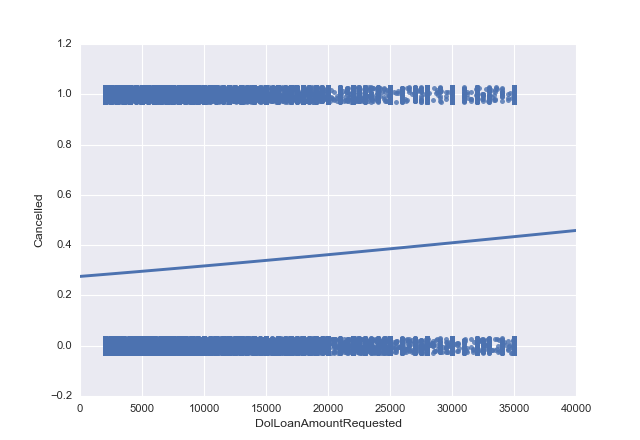

In [123]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
sns.regplot(x="DolLoanAmountRequested", y="Cancelled", data=reduced_data, logistic=True, y_jitter=.03, ci = None)

# Show the survival proability as a function of age and sex
#g = sns.lmplot(x="DolLoanAmountRequested", y="EnumListingStatus", data=reduced_data, logistic=True)
#g.set(xlim=(0, 80), ylim=(-.05, 1.05))

In [124]:
## 19 numerical variables only - show plot for each one. Also include column for cancellation.
numerics = reduced_data[['DolLoanAmountRequested','BorrowerRate','NumMonthsTerm','DolMonthlyIncome','FracDebtToIncomeRatio',\
'NumMonthsEmployed','DolPriorProsperLoansPrincipalBorrowed','NumPriorProsperLoansLatePayments',\
'NumTradesOpened6','NumOpenTradesDelinqOrPastDue6','DolTotalBalanceOnPublicRecords','NumRealEstateTrades',\
'DolMonthlyDebt','NumCurrentDelinquencies','NumPublicRecords12','DolAmountDelinquent','PctBankcardUtil',\
'NumTotalInquiries','DaysSinceFirstCredit','Cancelled']]

## 4 other boolean variables
booleans = reduced_data[['BoolPartialFundingApproved','BoolIsLender','BoolInGroup','BoolEverWholeLoan']]

## 4 categorical variables left: EnumListingCategory, StrEmploymentStatus, StrOccupation, EnumChannelCode

<IPython.core.display.Javascript object>


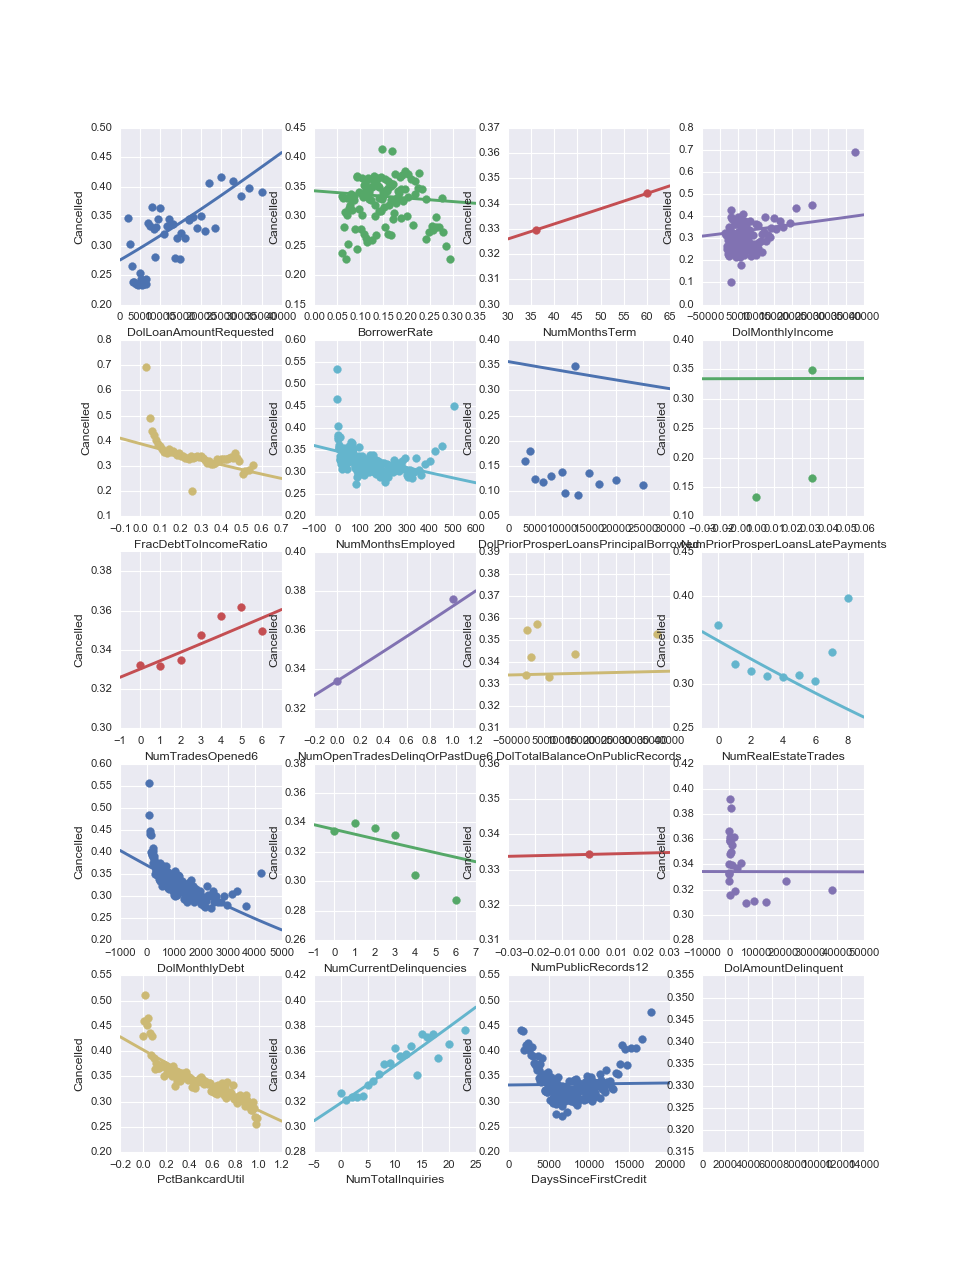

In [142]:
## create one big figure behind subpanels
fig, axes = plt.subplots(5,4,figsize=(12,16), facecolor='w')

## cycle through each numeric variable and logistic regress with cancellation (excluding cancellation itself)
for ax, var in zip(axes.reshape(-1),numerics.columns.values):
    sns.regplot(ax=ax, x=var, y="Cancelled", data=reduced_data, logistic=True, y_jitter=.03, ci = None, x_bins = 200)
    

In [138]:
qq = np.arange(100)
print(qq[:-1])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98]
